In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from copy import deepcopy
directory = "./result"
file_name = 'PhO-ox.npz'
random_seed = 2024
file_path = os.path.join(directory, file_name)

PhO-ox_npz = np.load(file_path, allow_pickle=True)

print("Arrays in the NPZ file:", PhO-ox_npz.files)
PhO-ox_data = PhO-ox_npz['data']
PhO-ox_columns = PhO-ox_npz['columns']
physorg_react_data_df = pd.DataFrame(PhO-ox_data, columns=PhO-ox_columns)

physorg_react_data_df.dropna(inplace=True) 

test_index = [87, 381, 316, 120, 479, 448, 197, 507, 198, 379, 508, 313, 265, 449, 453, 89, 292, 88, 121, 266, 454, 455, 447, 456, 271, 
              269, 294, 293, 297, 248, 249, 464, 312, 499, 289, 509, 511, 267, 166, 386, 290, 392, 498, 91, 488, 7, 278, 54, 285, 94, 303, 
              358, 444, 5, 286, 98, 458, 2, 291, 268, 470, 262, 308, 272, 53, 354, 512, 360, 495, 468, 391, 310, 307, 457, 306, 258, 352, 
              305, 357, 131, 362, 42, 311, 460, 304, 510, 298, 263, 350, 368, 100, 115, 61, 500, 56, 90, 442, 277, 487, 309, 0, 1, 356]

External_index = [462,119 ,396, 273, 375, 503, 318, 504, 472, 463, 465, 341, 342, 340, 477, 327, 348, 476,423 ,377, 332, 333, 182, 181,
                  349, 183, 112, 328, 323, 324, 113, 329, 330, 331, 144, 145,149, 150, 153, 151, 152, 154, 147, 485, 148, 482, 370, 373,
                  372, 146, 371]
all_indices = set(range(len(physorg_react_data_df)))
train_val_indices = sorted(list(all_indices - set(test_index) - set(External_index)))  
X = physorg_react_data_df.drop(columns=['YRed/Ox', 'compound_name'])
y = physorg_react_data_df['YRed/Ox']
X_train_val = X.iloc[train_val_indices]
y_train_val = y.iloc[train_val_indices]
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)

Arrays in the NPZ file: ['data', 'columns']


# Fine screening of hyperparameters and mapping of learning curves

In [2]:
from sklearn.linear_model import BayesianRidge
model = BayesianRidge()

param_grid = {
    'alpha_1': [1e-6, 1e-5, 1e-4],
    'alpha_2': [1e-6, 1e-5, 1e-4],
    'lambda_1': [1e-6, 1e-5, 1e-4],
    'lambda_2': [1e-6, 1e-5, 1e-4]
}

kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)

Grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=kfold, verbose=2, n_jobs=-1)

Grid_search.fit(X_train_val_scaled, y_train_val)

print("Best parameters:", Grid_search.best_params_)
best_model = Grid_search.best_estimator_


Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameters: {'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_1': 0.0001, 'lambda_2': 1e-06}


In [3]:
rates = [int(i) for i in np.linspace(0.1, 0.9, 20) * X_train_val_scaled.shape[0]]
print(rates)

r2_list = []
r2_std_list = []
r2_train_list = []
r2_train_std_list = []
random_seed = 2024
np.random.seed(random_seed)
model = BayesianRidge( alpha_1=1e-06, alpha_2=0.0001,lambda_1 =0.0001, lambda_2 =1e-06)
kf = KFold(n_splits=10, random_state=random_seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train_val_scaled, y_train_val, test_size=0.2, random_state=random_seed)
for rate in rates:
    r2s = []
    r2ts = []
    models = []
    y_pred = []
    maes = []
    rmses = []
    for train_index, val_index in kf.split(y_train):
        try:
            X_train_, X_test_, y_train_, y_test_ = train_test_split(
                X_train, y_train, train_size=rate)
        except:
            X_train_, y_train_ = X_train, y_train

        model.fit(X_train_, y_train_)
        models.append(deepcopy(model))
        y_pred.append(model.predict(X_test))
        valid_p, valid_y = model.predict(X_test), y_test
        r2 = r2_score(valid_y, valid_p)
        r2t = r2_score(model.predict(X_train_), y_train_)
        mae = mean_absolute_error(valid_y, valid_p)
        rmse = np.sqrt(mean_squared_error(valid_y, valid_p))
        r2s.append(r2)
        r2ts.append(r2t)
        maes.append(mae)
        rmses.append(rmse)
    
    valid_p, valid_y = np.array(y_pred).mean(axis=0), y_test
    r2 = np.array(r2s).mean(axis=0)
    r2_std = pd.DataFrame(r2s).std()[0]
    # print(r2_std)
    r2t = np.array(r2ts).mean(axis=0)
    r2t_std = pd.DataFrame(r2ts).std()[0]
    r2_list.append(r2)
    r2_train_list.append(r2t)
    r2_std_list.append(r2_std)
    r2_train_std_list.append(r2t_std)
    print(' $R^2$: {:.3}\n r2t: {:.3}\n r2std: {:.3}\n r2tstd: {:.3}'.format(
        r2, r2t, r2_std, r2t_std))
    
learning_curve = pd.DataFrame(columns=('r2', 'r2t', 'r2_std', 'r2t_std', 'num'))
learning_curve['r2'] = r2_list
learning_curve['r2t'] = r2_train_list
learning_curve['r2_std'] = r2_std_list
learning_curve['r2t_std'] = r2_train_std_list
learning_curve['num'] = rates
# learning_curve.to_csv('learn_curve.csv')
learning_curve

[36, 51, 67, 82, 97, 113, 128, 144, 159, 174, 190, 205, 220, 236, 251, 267, 282, 297, 313, 328]
 $R^2$: 0.624
 r2t: 0.979
 r2std: 0.135
 r2tstd: 0.0197
 $R^2$: 0.66
 r2t: 0.975
 r2std: 0.252
 r2tstd: 0.0294
 $R^2$: 0.734
 r2t: 0.964
 r2std: 0.145
 r2tstd: 0.0338
 $R^2$: 0.735
 r2t: 0.977
 r2std: 0.182
 r2tstd: 0.0183
 $R^2$: 0.765
 r2t: 0.977
 r2std: 0.107
 r2tstd: 0.0164
 $R^2$: 0.829
 r2t: 0.979
 r2std: 0.0573
 r2tstd: 0.018
 $R^2$: 0.819
 r2t: 0.98
 r2std: 0.0844
 r2tstd: 0.013
 $R^2$: 0.78
 r2t: 0.981
 r2std: 0.158
 r2tstd: 0.00454
 $R^2$: 0.798
 r2t: 0.975
 r2std: 0.111
 r2tstd: 0.00599
 $R^2$: 0.83
 r2t: 0.972
 r2std: 0.11
 r2tstd: 0.00648
 $R^2$: 0.79
 r2t: 0.977
 r2std: 0.123
 r2tstd: 0.00462
 $R^2$: 0.88
 r2t: 0.975
 r2std: 0.058
 r2tstd: 0.00574
 $R^2$: 0.835
 r2t: 0.974
 r2std: 0.0889
 r2tstd: 0.00682
 $R^2$: 0.88
 r2t: 0.97
 r2std: 0.0359
 r2tstd: 0.00489
 $R^2$: 0.878
 r2t: 0.973
 r2std: 0.0573
 r2tstd: 0.003
 $R^2$: 0.898
 r2t: 0.97
 r2std: 0.0171
 r2tstd: 0.00171
 $R^2$:

,r2,r2t,r2_std,r2t_std,num
0,0.623519,0.979305,0.134584,0.019718,36
1,0.660371,0.975101,0.251704,0.029384,51
2,0.733686,0.964158,0.145181,0.033831,67
3,0.734501,0.976610,0.182418,0.018312,82
4,0.764847,0.976894,0.107350,0.016433,97
5,0.828894,0.978656,0.057256,0.018026,113
6,0.819130,0.980229,0.084412,0.013007,128
7,0.779512,0.981234,0.158183,0.004540,144
8,0.798322,0.975221,0.111190,0.005993,159
9,0.830154,0.972332,0.110134,0.006483,174


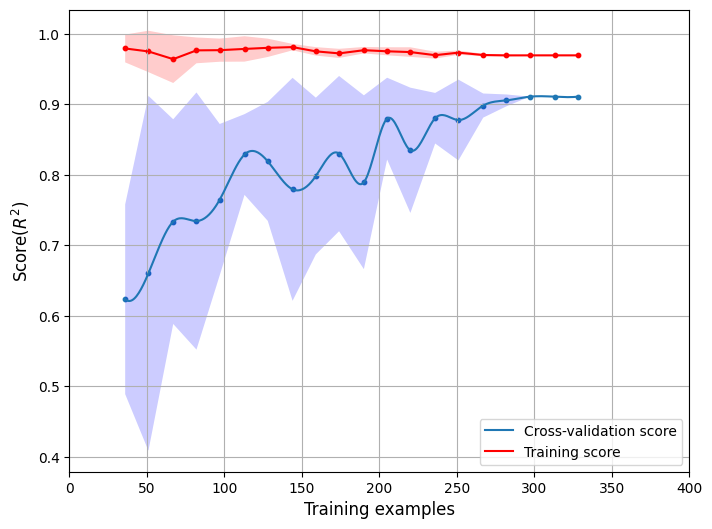

In [4]:
labels = rates  

min_label = min(labels)
max_label = max(labels)
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
r2 = learning_curve['r2']
r2t = learning_curve['r2t']
r2std = learning_curve['r2_std']
r2tstd = learning_curve['r2t_std']
labels = rates


xnew = np.linspace(min_label, max_label, 400)
func_1 = interp1d(labels, r2, kind='cubic')
r2_new = func_1(xnew)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(xnew,r2_new, '-', label = 'Cross-validation score')  
# ax.plot(labels, r2, '-', label = 'Cross-validation score')
ax.scatter(labels, r2, s=10)
ax.fill_between(labels, r2-r2std, r2+r2std, alpha=0.2, facecolor='b')


ax.plot(labels, r2t, '-r', label = 'Training score')
ax.scatter(labels, r2t, s=10, c='r')
ax.fill_between(labels, r2t-r2tstd, r2t+r2tstd, alpha=0.2, facecolor='r')
plt.xlim((0, 400))
plt.legend(loc='lower right')

ax.set_xlabel("Training examples", fontsize=12)
ax.set_ylabel("Score($R^2$)", fontsize=12)
ax.grid()
plt.savefig("./result/learning curve-PhO.tif", dpi=600)
plt.savefig('./result/learning curve-PhO.png', dpi=600)

# Feature Engineering - Feature Screening

In [5]:
'''
The dataset is divided into training/validation and out-of-sample (OOS) test sets based on predefined indices. 
The division process ensures that the test data is completely held out during the training and validation phases 
to properly evaluate the model's performance on unseen data.

- `test_index`: This is the primary set of indices used to define the initial part of the OOS test set.
- `test_index_db2`: Additional test indices derived by adding half the length of the dataset (`length_db`) to each index in `test_index`.
  This approach accounts for the potential scenario where test data points are distributed across the dataset.

The following steps are executed in the code:
1. `length_db` is calculated as half the total number of data points, used to adjust the indices for the second half of the dataset.
2. `test_index_db2` is generated to cover any test data points that might appear in the latter half of the dataset.
3. `full_test_index` combines `test_index` and `test_index_db2` to form the complete set of indices for the OOS test set.
4. The data points at these indices are then extracted as the OOS test set (`oos_x`, `oos_y`), ensuring they are not used in model training or validation.
5. The remaining data points are used to create the training/validation set (`X_scaled`, `y_train_val`), which is also standardized to aid in model training.
'''

directory = "./result"
file_name = 'PhO-ox.npz'

file_path = os.path.join(directory, file_name)

PhO-ox_npz = np.load(file_path, allow_pickle=True)

print("Arrays in the NPZ file:", PhO_rdkit_maccs_npz.files)
PhO-ox_data = PhO-ox_npz['data']
PhO-ox_columns = PhO-ox_npz['columns']
physorg_react_data_df = pd.DataFrame(PhO-ox_data, columns=PhO-ox_columns)

physorg_react_data_df.dropna(inplace=True) 


test_index = [87, 381, 316, 120, 479, 448, 197, 507, 198, 379, 508, 313, 265, 449, 453, 89, 292, 88, 121, 266, 454, 455, 447, 456, 271, 
              269, 294, 293, 297, 248, 249, 464, 312, 499, 289, 509, 511, 267, 166, 386, 290, 392, 498, 91, 488, 7, 278, 54, 285, 94, 303, 
              358, 444, 5, 286, 98, 458, 2, 291, 268, 470, 262, 308, 272, 53, 354, 512, 360, 495, 468, 391, 310, 307, 457, 306, 258, 352, 
              305, 357, 131, 362, 42, 311, 460, 304, 510, 298, 263, 350, 368, 100, 115, 61, 500, 56, 90, 442, 277, 487, 309, 0, 1, 356]

External_index = [462,119 ,396, 273, 375, 503, 318, 504, 472, 463, 465, 341, 342, 340, 477, 327, 348, 476,423 ,377, 332, 333, 182, 181,
                  349, 183, 112, 328, 323, 324, 113, 329, 330, 331, 144, 145,149, 150, 153, 151, 152, 154, 147, 485, 148, 482, 370, 373,
                  372, 146, 371]

all_indices = set(range(len(physorg_react_data_df)))
train_val_indices = sorted(list(all_indices - set(test_index) - set(External_index)))  
X = physorg_react_data_df.drop(columns=['YRed/Ox', 'compound_name'])
y = physorg_react_data_df['YRed/Ox']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.iloc[train_val_indices])
y_train_val = y.iloc[train_val_indices]
test_x = scaler.transform(X.iloc[test_index])
test_y = y.iloc[test_index]

Arrays in the NPZ file: ['data', 'columns']


In [6]:
random_seed = 2024
from sklearn.feature_selection import RFECV
# The max_depth and n_estimators are identified by hyperparameters optimization procedure, which is demonstrated in Notebook 3.
model = BayesianRidge( alpha_1=1e-06, alpha_2=0.0001,lambda_1 =0.0001, lambda_2 =1e-06)
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
selector = RFECV(model, step=1, min_features_to_select=1,cv=cv, n_jobs=-1)
selector = selector.fit(X_scaled, y_train_val)
sel_index = np.where(selector.support_==True)[0]
print('----Reserved Descriptors----')
print('Size: %d'%len(sel_index))
print('Index of selected descriptors', sel_index + 1)

----Reserved Descriptors----
Size: 76
Index of selected descriptors [  1   2   3   4   7   8   9  10  13  14  15  19  22  25  26  27  29  31
  32  33  34  35  36  37  39  40  41  42  43  44  45  46  47  49  50  51
  52  53  55  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  75  76  77  78  79  80  82  83  84  85  86  87  88  90  91  93  96
  98  99 100 101]


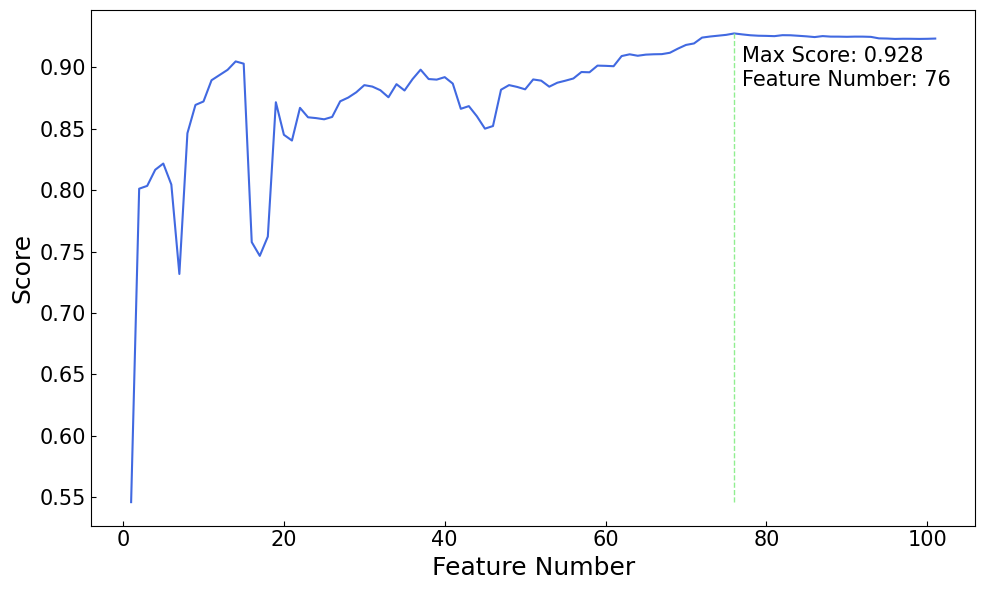

In [7]:
fig = plt.figure(figsize=(10, 6))  

y_r2 = selector.cv_results_['mean_test_score']
x_1_index = [item + 1 for item in range(len(y_r2))]

max_index = np.argmax(y_r2) + 1
max_score = np.max(y_r2)

plt.plot(x_1_index, y_r2, c='royalblue')

plt.plot([max_index, max_index], [np.min(y_r2), max_score], c='lightgreen', linewidth=1, linestyle='--')


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.text(max_index + 1, max_score - 0.010, f'Max Score: {max_score:.3f}', fontsize=15, verticalalignment='top')
plt.text(max_index + 1, max_score - 0.030, f'Feature Number: {max_index}', fontsize=15, verticalalignment='top')

plt.xlabel('Feature Number', fontsize=18)
plt.ylabel('Score', fontsize=18)

plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)

plt.tight_layout()
plt.savefig('./RFECV-PhO.png', dpi=600)
plt.savefig('./RFECV-PhO.tif', dpi=600)
plt.show()

# Model Training

Training set

In [8]:
from scipy.stats import pearsonr
val_Y = []
val_P = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for train_idx,val_idx in kfold.split(X_scaled):
    train_x,val_x = X_scaled[:,sel_index][train_idx],X_scaled[:,sel_index][val_idx]
    train_y,val_y = y_train_val.iloc[train_idx],y_train_val.iloc[val_idx]
    val_P_ = []
    for try_ in range(10): 
        model.fit(train_x,train_y)
        val_p = model.predict(val_x)
        val_P_.append(val_p)
    val_P_ = np.mean(val_P_,axis=0)
    val_P.append(val_P_)
    val_Y.append(val_y)
val_P = np.concatenate(val_P)
val_Y = np.concatenate(val_Y)
mae = mean_absolute_error(val_Y,val_P)
r2 = r2_score(val_Y,val_P)
pearson_r,_ = pearsonr(val_Y,val_P)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.0549, R2: 0.9449, Pearson R: 0.9721


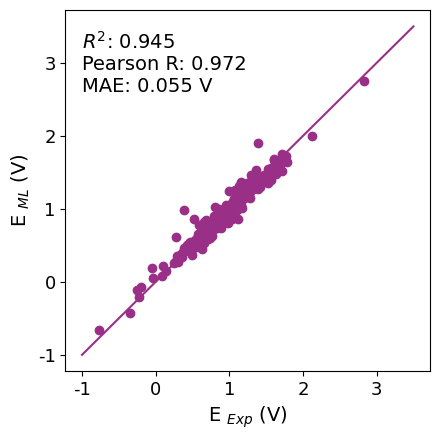

In [9]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(val_Y,val_P,c='#992f87')

plt.text(-1,3.2,'$R^2$: %.3f'%r2_score(val_Y,val_P),fontsize=14)
plt.text(-1,2.9,'Pearson R: %.3f'%pearsonr(val_Y,val_P)[0],fontsize=14)
plt.text(-1,2.6,'MAE: %.3f V'%mean_absolute_error(val_Y,val_P),fontsize=14)

plt.plot([-1,3.5],[-1,3.5],c='#992f87')
plt.xlabel('E $_{Exp}$ (V)',fontsize=14)
plt.ylabel('E $_{ML}$ (V)',fontsize=14)
plt.xticks([-1, 0,1,2,3],list(map(str,[-1, 0,1,2,3])),fontsize=13)
plt.yticks([-1, 0,1,2,3],list(map(str,[-1, 0,1,2,3])),fontsize=13)

plt.tick_params(bottom='on',left='on')
plt.tight_layout()
plt.savefig('./result/CV-E-BRPhO.tif', dpi=600) 
plt.savefig('./result/CV-E-BRPhO.png', dpi=600)

Test set

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error

test_P = []
feature_importance = []

for _ in range(10):
    model.fit(X_scaled[:, sel_index], y_train_val)
    
    feature_importance.append(np.abs(model.coef_))
    
    test_p = model.predict(test_x[:, sel_index])
    test_P.append(test_p)

test_p = np.mean(test_P, axis=0)
feature_importance = np.mean(feature_importance, axis=0)

sel_feature_names = np.array(PhO_rdkit_maccs_columns)[sel_index + 1]

sorted_feature_index = np.argsort(feature_importance)
importance_desc_names = sel_feature_names[sorted_feature_index]
importance_of_sel_desc = feature_importance[sorted_feature_index]

r2 = r2_score(test_y, test_p)
pearson_r, _ = pearsonr(test_y, test_p)
mae = mean_absolute_error(test_y, test_p)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f" % (mae, r2, pearson_r))


MAE: 0.0785, R2: 0.9090, Pearson R: 0.9552


In [136]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(test_y,test_p,c='#D89090')
plt.text(-1,3.2,'$R^2$: %.3f'%r2_score(test_y,test_p),fontsize=14)
plt.text(-1,2.9,'Pearson R: %.3f'%pearsonr(test_y,test_p)[0],fontsize=14)
plt.text(-1,2.6,'MAE: %.3f V'%mean_absolute_error(test_y,test_p),fontsize=14)
plt.plot([-1,3.5],[-1,3.5],c='#D89090')
plt.xlabel('E $_{Exp}$ (V)',fontsize=14)
plt.ylabel('E $_{ML}$ (V)',fontsize=14)
plt.xticks([-1,0,1,2,3],list(map(str,[-1,0,1,2,3])),fontsize=13)
plt.yticks([-1,0,1,2,3],list(map(str,[-1,0,1,2,3])),fontsize=13)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()
plt.savefig('./result/CV-E-BRPhO-oos.tif', dpi=600) 
plt.savefig('./result/CV-E-BRPhO-oos.png', dpi=600)

# Comparison of real and projected data

In [124]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
def fixed_selector_transform(X):
    return X[:, sel_index]

fixed_selector = FunctionTransformer(fixed_selector_transform)

pipeline = Pipeline([
    ('scaler', scaler),
    ('fixed_selector', fixed_selector),
    ('model', model)
])

X_full = np.vstack((X.iloc[train_val_indices], X.iloc[test_index]))  
y_full = np.concatenate((y_train_val, test_y))

pipeline.fit(X_full, y_full)

import shap
import joblib

X_scaled_full = pipeline.named_steps['scaler'].transform(X_full)
X_selected_full = pipeline.named_steps['fixed_selector'].transform(X_scaled_full)

explainer = shap.LinearExplainer(pipeline.named_steps['model'], X_selected_full)
shap_values = explainer.shap_values(X_selected_full)

# save pipeline
joblib.dump(pipeline, 'Gox.joblib')


['Gred.joblib']

In [20]:
y_pred_full = pipeline.named_steps['model'].predict(X_selected_full)

selected_feature_names = importance_desc_names 

y_true_aligned = y_full

df = pd.DataFrame(X_scaled_full[:,sel_index], columns=selected_feature_names)

df['Predicted_Y'] = y_pred_full

df['True_Y'] = y_true_aligned

missing_true_y = df['True_Y'].isna().sum()
if missing_true_y > 0:
    print(f"发现{missing_true_y}个真实值的空白，尝试修复索引对齐...")

df = df.dropna(subset=['True_Y']).reset_index(drop=True)

print(df)
df.to_csv('selected_features_and_predicted_y_with_true_y.csv', index=False)


     LEAmax_2  Overall_Variance_2  Dipole_Moment_2        Pi       SDP  \
0   -0.650323            0.451838         0.614766 -0.683710  0.617950   
1   -1.253248            1.056319         0.749852 -1.159790  0.777390   
2   -1.141638            0.939752         0.700115 -1.052869  0.707627   
3    1.091372           -0.887447        -0.806837  1.087263 -1.063263   
4    1.084750           -0.893398        -0.789052  1.079753 -1.053365   
..        ...                 ...              ...       ...       ...   
463 -0.637706            0.447525         0.743575 -0.763149  0.856930   
464  1.107472           -0.884730        -0.851430  1.113910 -1.089319   
465 -0.324911            0.203784         0.406100 -0.390597  0.299130   
466 -0.902431            0.641716         0.695321 -0.857609  0.731716   
467  0.908228           -0.711972        -0.743370  0.933558 -0.993977   

     Neg_Average  Quadrupole_Moment_2   Density  Mol_Size_Short_2   LEA_Ave  \
0      -0.650324            -0.7

# Shap analysis and normalized presentation and data processing

Feature Importance (before and after normalization):
Pos_Average_2: Original SHAP Value = 4.4865, Normalized SHAP Value = 0.0018
Len_Div_Diameter_2: Original SHAP Value = 4.7051, Normalized SHAP Value = 0.0019
Density: Original SHAP Value = 5.7032, Normalized SHAP Value = 0.0023
Length_Ratio_2: Original SHAP Value = 5.7518, Normalized SHAP Value = 0.0024
LEAmin: Original SHAP Value = 6.1748, Normalized SHAP Value = 0.0025
Overall_Variance_2: Original SHAP Value = 7.0498, Normalized SHAP Value = 0.0029
LEAmin_2: Original SHAP Value = 7.3594, Normalized SHAP Value = 0.0030
Len_Div_Diameter: Original SHAP Value = 7.4849, Normalized SHAP Value = 0.0031
Mol_Size_Short_2: Original SHAP Value = 7.8340, Normalized SHAP Value = 0.0032
Overall_Variance: Original SHAP Value = 7.8960, Normalized SHAP Value = 0.0032
Overall_Surface_Area: Original SHAP Value = 7.9717, Normalized SHAP Value = 0.0033
Dipole_Moment_2: Original SHAP Value = 8.2620, Normalized SHAP Value = 0.0034
Quadrupole_Moment_2: Ori

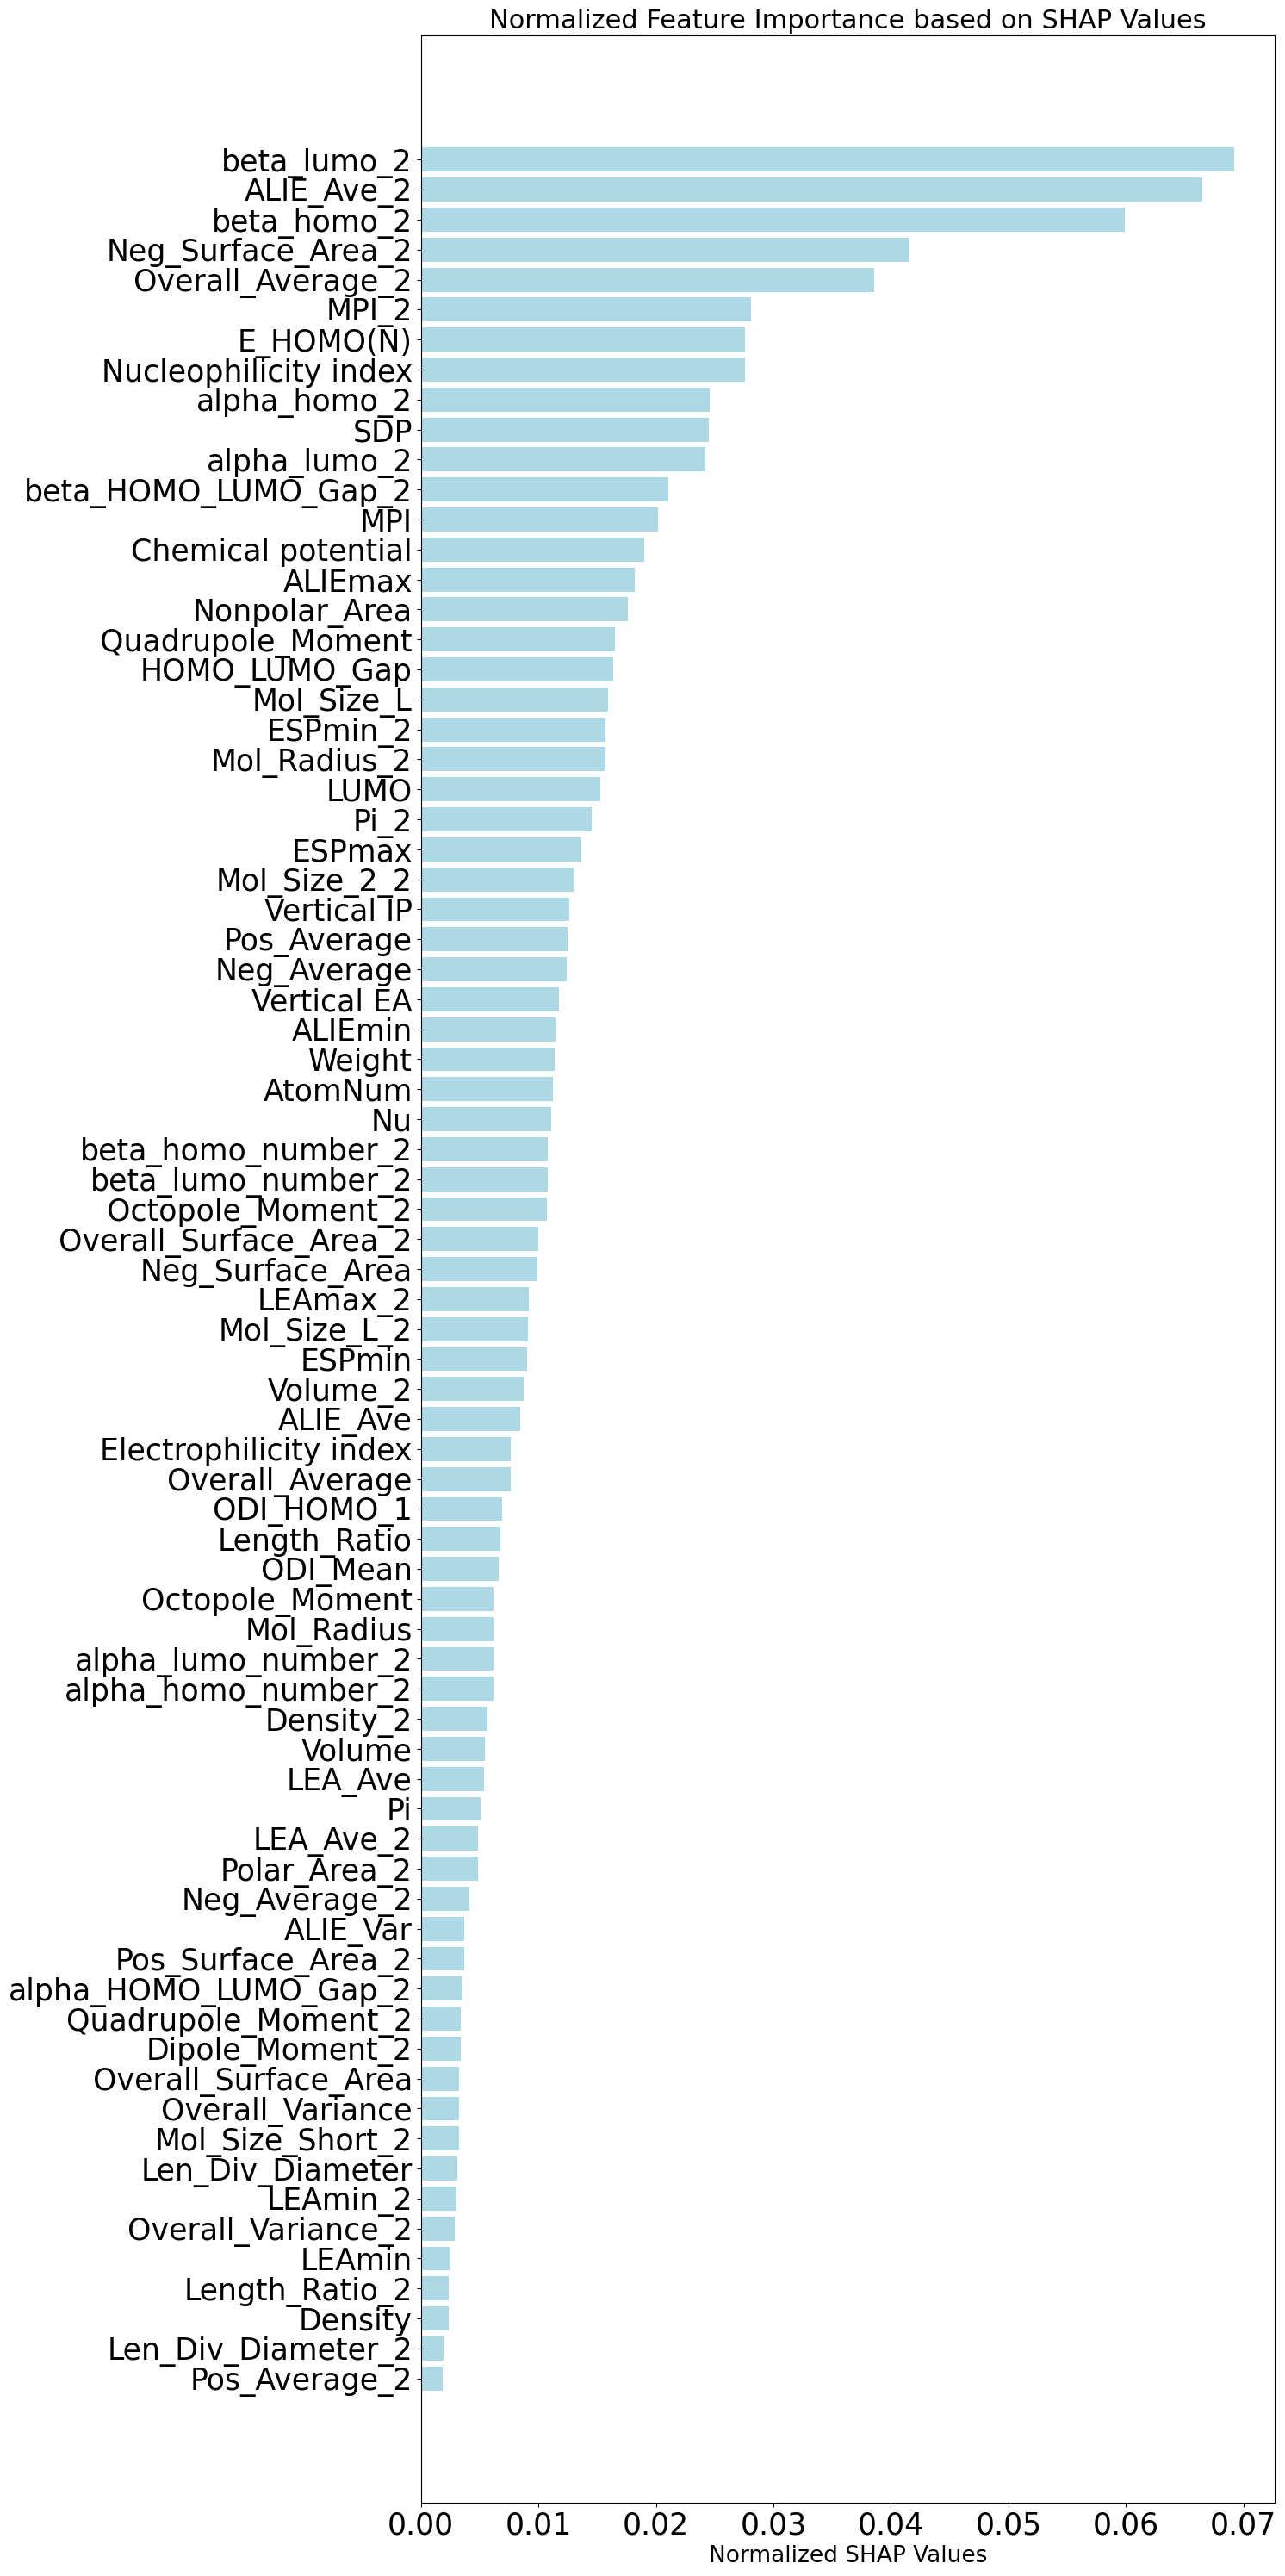

In [37]:
shap_abs_sum = np.sum(np.abs(shap_values), axis=0)

shap_values_normalized = shap_abs_sum / np.sum(shap_abs_sum)

sorted_indices = np.argsort(shap_values_normalized)

importance_desc_names = np.array(PhO_rdkit_maccs_columns)[sel_index + 1][sorted_indices]
importance_of_sel_desc = shap_values_normalized[sorted_indices]

print("Feature Importance (before and after normalization):")
for i in range(len(importance_desc_names)):
    print(f"{importance_desc_names[i]}: Original SHAP Value = {shap_abs_sum[sorted_indices[i]]:.4f}, Normalized SHAP Value = {importance_of_sel_desc[i]:.4f}")
    
fig = plt.figure(figsize=(15, 30))
plt.barh(importance_desc_names, importance_of_sel_desc, color='lightblue', align='center')
plt.xlabel('Normalized SHAP Values', fontsize=19)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Normalized Feature Importance based on SHAP Values', fontsize=22)
plt.tight_layout()

plt.savefig('./result/importance_desc_names_normalized.png', dpi=600)
plt.show()


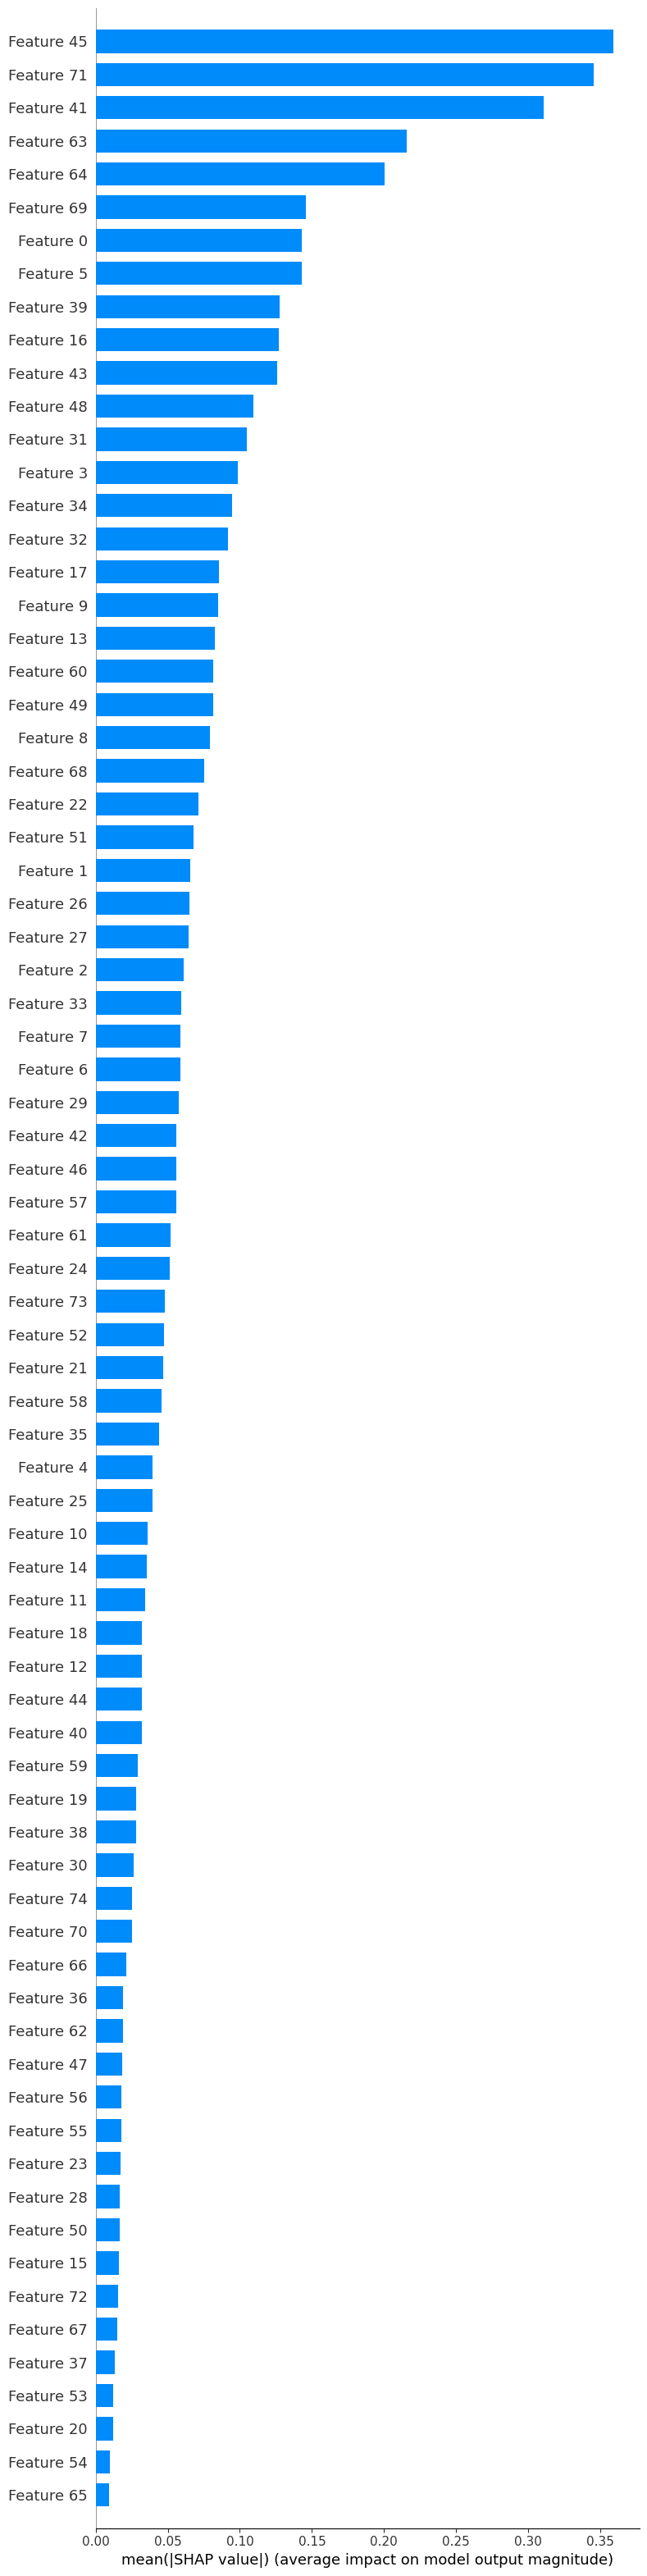

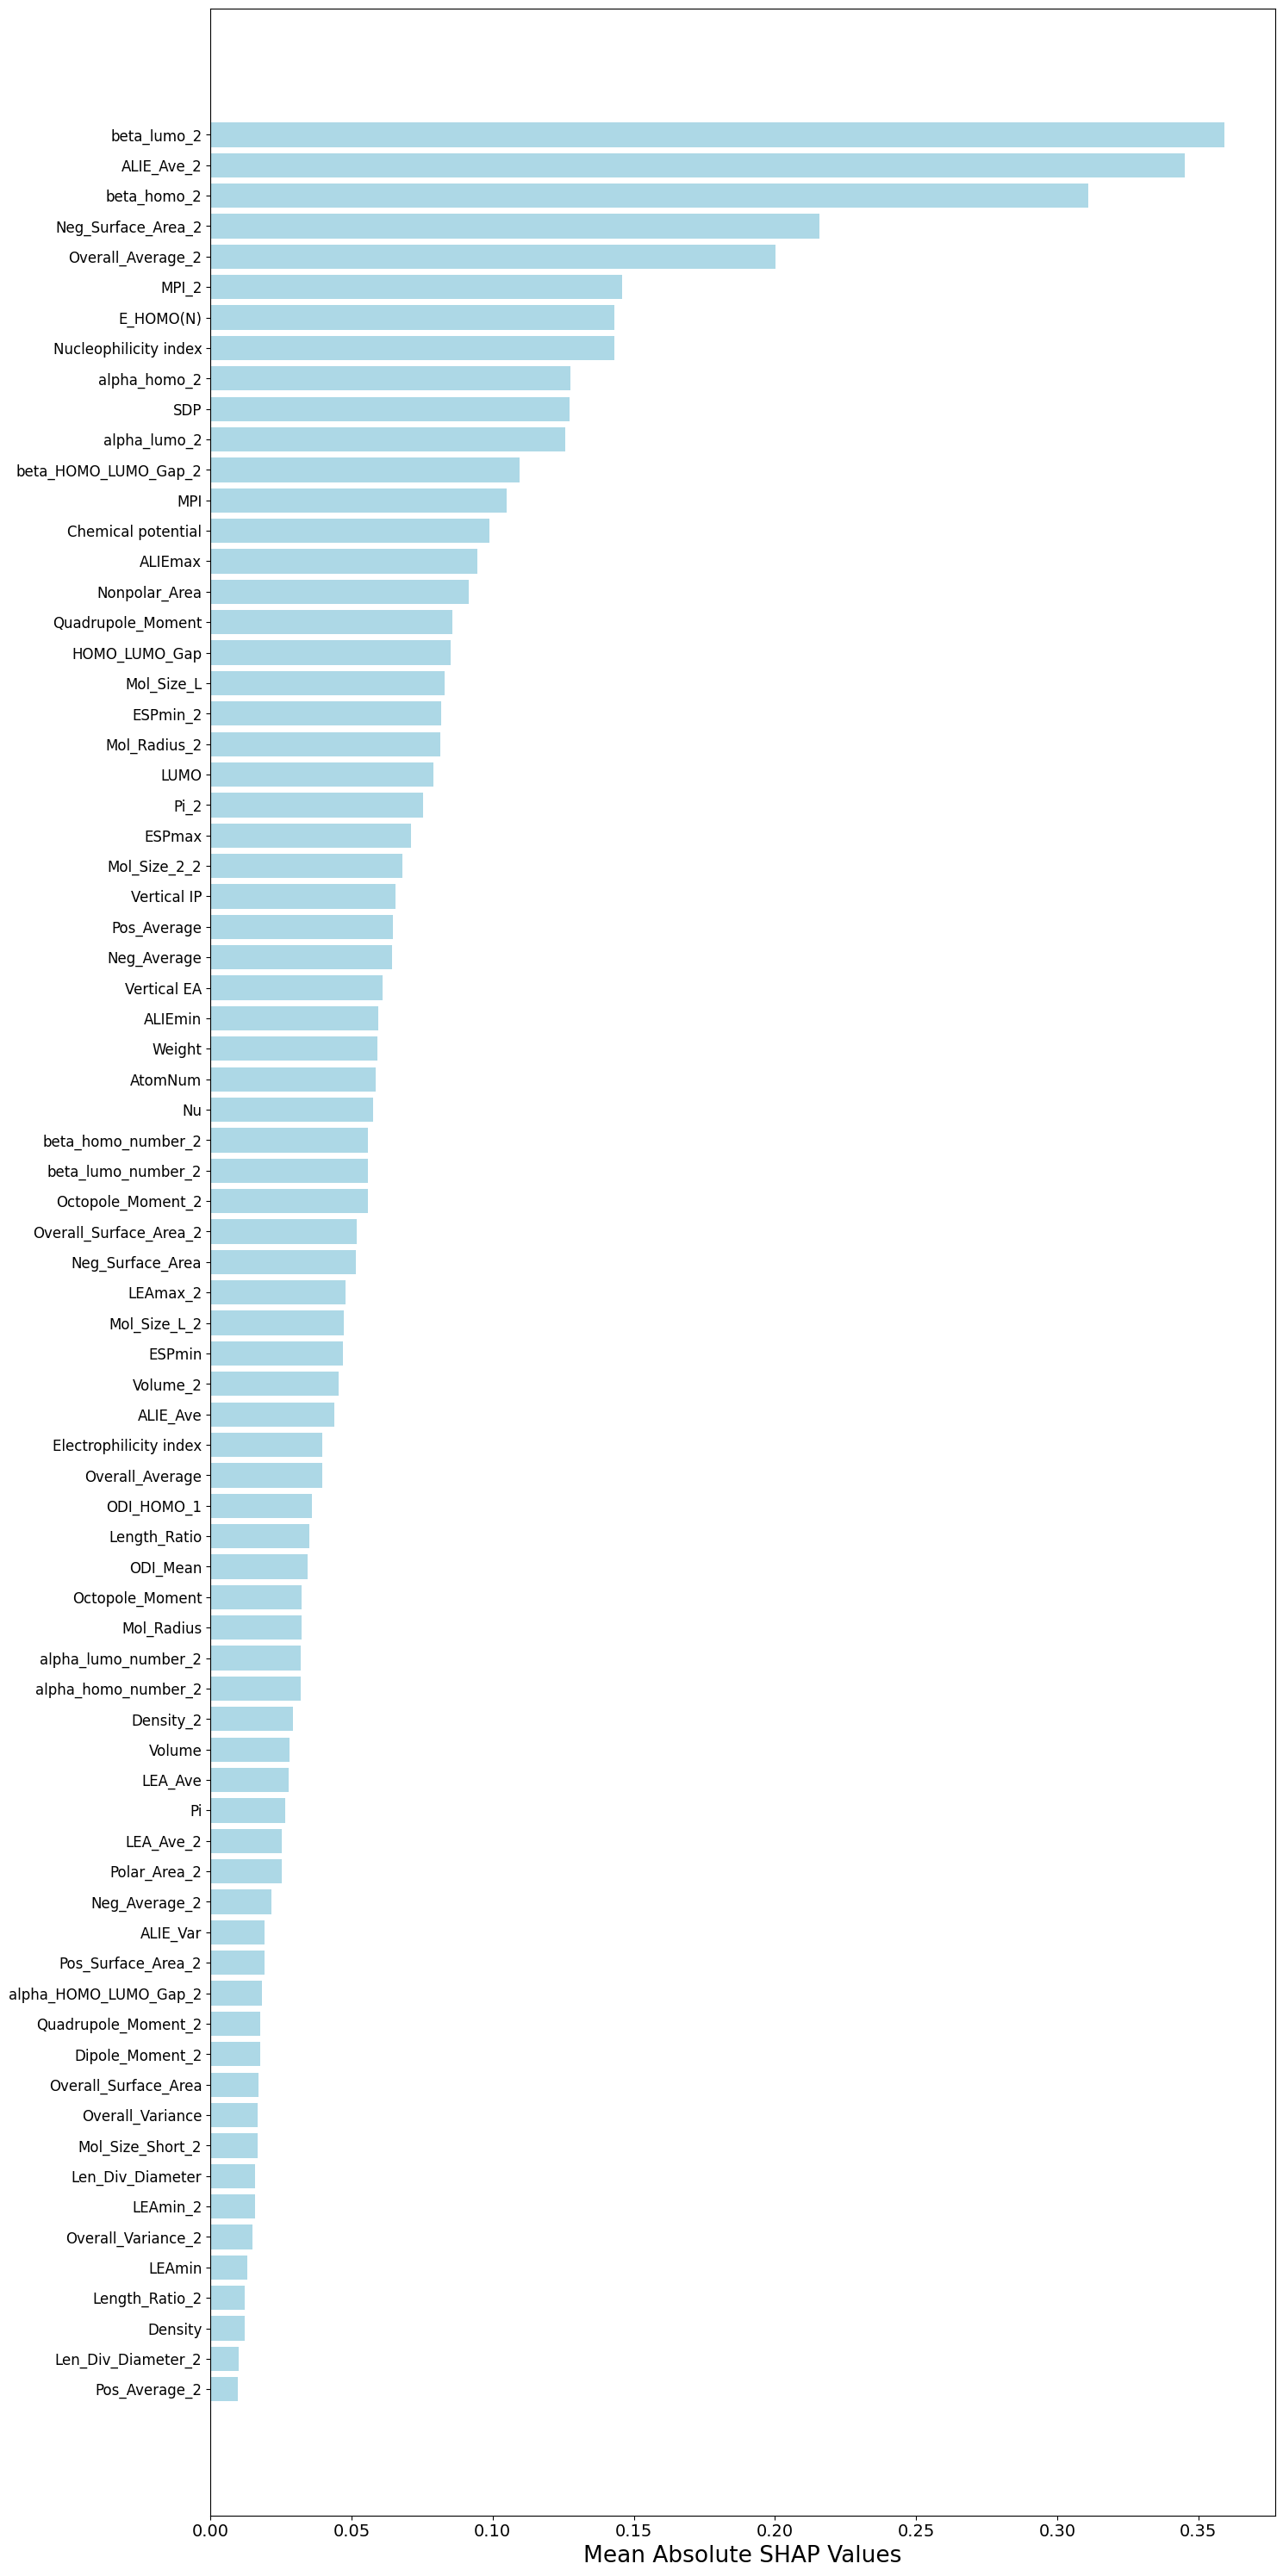

In [41]:
import shap

shap.summary_plot(
    shap_values, 
    X_selected_full, 
    plot_type="bar", 
    max_display=X_selected_full.shape[1] 
)

mean_shap_values = np.abs(shap_values).mean(axis=0)

importance_desc_names = np.array(PhO_rdkit_maccs_columns)[sel_index + 1][np.argsort(mean_shap_values)]
importance_of_sel_desc = mean_shap_values[np.argsort(mean_shap_values)]

fig = plt.figure(figsize=(15, X_selected_full.shape[1] * 0.4))
plt.barh(importance_desc_names, importance_of_sel_desc, color='lightblue', align='center')
plt.xlabel('Mean Absolute SHAP Values', fontsize=19)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [96]:
shap.summary_plot(shap_values, X_selected_full, feature_names=np.array(PhO_rdkit_maccs_columns)[sel_index+1])

plt.suptitle("Normalized Feature Importance based on SHAP", fontsize=20)

plt.tight_layout()

plt.savefig('./result/shap_summary_plot.png', dpi=600)
plt.show()


In [109]:
import matplotlib.pyplot as plt
plt.close('all') 

import gc
gc.collect() 


28868

In [100]:
shap.summary_plot(shap_values, X_selected_full, feature_names=np.array(PhO_rdkit_maccs_columns)[sel_index+1], max_display=3)

plt.gca().tick_params(axis='y', labelsize=16) 
plt.tight_layout()
plt.savefig('./result/shap_summary_plot-little.png', dpi=600)
plt.show()


In [123]:
feat_names = np.array(selected_feature_names)[: X_selected_full.shape[1]]

max_index = np.argmax(y_pred_full)

shap_values_max_sample = shap_values[max_index]
X_max_sample = X_selected_full[max_index]

X_max_sample = np.round(X_max_sample, 3)
shap_values_max_sample = np.round(shap_values_max_sample, 3)

force_plot = shap.force_plot(
    explainer.expected_value, 
    shap_values_max_sample, 
    X_max_sample, 
    feature_names=feat_names, 
    matplotlib=True
)

plt.savefig('./result/shapcolorplot-max-Y-improved.jpeg', dpi=600, format='jpeg', bbox_inches='tight')
plt.show()


In [122]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 16

force_plot = shap.force_plot(
    explainer.expected_value, 
    shap_values_min_sample, 
    X_min_sample, 
    feature_names=feat_names, 
    matplotlib=True
)

fig = plt.gcf()

for ax in fig.get_axes():
    for text in ax.texts:
        txt = text.get_text()
        x, y = text.get_position()

        if 'f(x)' in txt:
            text.set_position((x, y + 0.05))
        elif 'base value' in txt:
            text.set_position((x, y - 0.05))
        
        elif "MPI_2" in txt:
            text.set_position((x + 0.2, y)) 
        elif "Vertical IP" in txt:
            text.set_position((x + 0.4, y))
        elif "LEAmin" in txt:
            text.set_position((x - 0.4, y)) 
        elif "beta_lumo_number_2" in txt:
            text.set_position((x - 0.5, y))

        text.set_fontsize(18)

plt.savefig('./result/shapcolorplot-min-Y-improved.jpeg', dpi=600, format='jpeg', bbox_inches='tight')
plt.show()


# Save model and out-of-bank test set testing

In [129]:
pipeline = joblib.load('Gox.joblib')
X_external = X.iloc[External_index]
y = physorg_react_data_df['YRed/Ox']
y_external = y.iloc[External_index]
ext_pred = pipeline.predict(X_external.to_numpy())
compound_names = physorg_react_data_df['compound_name']
compound_names_external = compound_names.iloc[External_index]


In [130]:
results = pd.DataFrame({
    'Compound Name': compound_names_external.values,
    'Predicted Value': ext_pred,
    'Eexp': y_external.values
})

print(results)



                        Compound Name  Predicted Value  Eexp
0                 Ir-q-bt-Me2-acac-ox         0.516493  0.52
1                  Ir(dfppz)2Phtz+-ox         1.326155  1.33
2                    Irppo-acacSPh-ox         0.813078   0.8
3                 Ir3CFbt-HbpdcNMe-ox         1.236783  1.21
4                          IrmpbiL-ox         0.375917  0.44
5               mer-Ir(dfppz)2(pf)-ox         0.611769  0.66
6                          IrcpbiL-ox         0.754179  0.88
7              mer-Ir(dfppz)2(ptp)-ox         0.628920  0.74
8                          IrthbiL-ox         0.560965  0.63
9                 Ir-q-bt-Me2-bpy+-ox         0.778151  0.76
10               Ir-q-bt-Ph2-phen+-ox         0.823558   0.8
11                Irdfppy-CO2Mepic-ox         0.955724   1.0
12                Irdfppy-COCF3pic-ox         1.075841  1.17
13                   Irdfppy-CNpic-ox         1.111337  1.19
14              Ir-tPhTAZ2-phpybi+-ox         1.007883   1.0
15                Ir-dFC

In [ ]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(test_y,test_p,c='#D89090')
plt.text(-1,3.2,'$R^2$: %.3f'%r2_score(test_y,test_p),fontsize=14)
plt.text(-1,2.9,'Pearson R: %.3f'%pearsonr(test_y,test_p)[0],fontsize=14)
plt.text(-1,2.6,'MAE: %.3f V'%mean_absolute_error(test_y,test_p),fontsize=14)
plt.plot([-1,3.5],[-1,3.5],c='#D89090')
plt.xlabel('E $_{Exp}$ (V)',fontsize=14)
plt.ylabel('E $_{ML}$ (V)',fontsize=14)
plt.xticks([-1,0,1,2,3],list(map(str,[-1,0,1,2,3])),fontsize=13)
plt.yticks([-1,0,1,2,3],list(map(str,[-1,0,1,2,3])),fontsize=13)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()
plt.savefig('./result/CV-E-BRPhO-oos.tif', dpi=600) 
plt.savefig('./result/CV-E-BRPhO-oos.png', dpi=600)

In [137]:
ext_r2 = r2_score(y_external,ext_pred)
ext_mae = mean_absolute_error(y_external,ext_pred)
ext_pearson_r = pearsonr(y_external,ext_pred)[0]

plt.figure(figsize=(4.5,4.5))

plt.scatter(y_external,ext_pred,c='#efae42')

plt.text(-1,3.2,'$R^2$: %.3f'%ext_r2,fontsize=14)
plt.text(-1,2.9,'Pearson R: %.3f'%ext_pearson_r,fontsize=14)
plt.text(-1,2.6,'MAE: %.3f V'%ext_mae,fontsize=14)

plt.plot([-1,3.5],[-1,3.5],c='#efae42')
plt.xlabel('E $_{Exp}$ (V)',fontsize=14)
plt.ylabel('E $_{ML}$ (V)',fontsize=14)
plt.xticks([-1, 0,1,2,3],list(map(str,[ -1, 0,1,2,3])),fontsize=13)
plt.yticks([ -1, 0,1,2,3],list(map(str,[ -1, 0,1,2,3])),fontsize=13)
plt.tick_params(bottom='on',left='on')

plt.tight_layout()
plt.savefig('./result/external-GBRPhO.tif', dpi=600) 
plt.savefig('./result/external-GBRPhO.png', dpi=600)

# Regression curve plotting and error calculation

In [133]:
from sklearn.metrics import r2_score, mean_absolute_error

train_r2 = r2_score(val_Y, val_P)
train_pearson_r, _ = pearsonr(val_Y, val_P)
train_mae = mean_absolute_error(val_Y, val_P)

test_r2 = r2_score(test_y, test_p)
test_pearson_r, _ = pearsonr(test_y, test_p)
test_mae = mean_absolute_error(test_y, test_p)

ext_r2 = r2_score(y_external, ext_pred)
ext_mae = mean_absolute_error(y_external, ext_pred)
ext_pearson_r = pearsonr(y_external, ext_pred)[0]

re_train = np.abs(val_P - val_Y) / np.abs(val_Y)
re_test = np.abs(test_p - test_y) / np.abs(test_y)
re_ext = np.abs(ext_pred - y_external) / np.abs(y_external)

accuracy_train = np.mean(re_train <= 0.3) * 100
accuracy_test = np.mean(re_test <= 0.3) * 100
accuracy_ext = np.mean(re_ext <= 0.3) * 100
accuracy_train1 = np.mean(re_train <= 0.2) * 100
accuracy_test1 = np.mean(re_test <= 0.2) * 100
accuracy_ext1 = np.mean(re_ext <= 0.2) * 100

print(f"Training Accuracy (RE±0.3): {accuracy_train:.2f}%")
print(f"Test Accuracy (RE±0.3): {accuracy_test:.2f}%")
print(f"External Test Accuracy (RE±0.3): {accuracy_ext:.2f}%")
print(f"Training Accuracy (RE±0.2): {accuracy_train1:.2f}%")
print(f"Test Accuracy (RE±0.2): {accuracy_test1:.2f}%")
print(f"External Test Accuracy (RE±0.2): {accuracy_ext1:.2f}%")

plt.figure(figsize=(6, 6))

plt.scatter(val_Y, val_P, c='#1F2124', label='Training Set', alpha=0.6)

plt.scatter(test_y, test_p, c='#89AA7B', label='Test Set', alpha=0.6)
plt.text(1.1, -0.3, '$R^2$: %.3f' % test_r2, fontsize=18)
plt.text(1.1,-0.55, 'Pearson R: %.3f' % test_pearson_r, fontsize=18)
plt.text(1.1,-0.80, 'MAE: %.3f V' % test_mae, fontsize=18)
plt.text(1.1,-1.05, f'RE±0.3: {accuracy_test:.2f}%', fontsize=18)
plt.text(1.1,-1.3, f'RE±0.2: {accuracy_test1:.2f}%', fontsize=18)

plt.scatter(y_external, ext_pred, c='#efae42', label='External Test Set', alpha=0.6)

plt.plot([-1,3],[-1,3],c='black', linestyle='--', label='Ideal Fit')

plt.plot([-1, 3], [-1 + 0.3, 3 + 0.3], c='orange', linestyle='--', label='Error bounds of ±0.3 V')
plt.plot([-1, 3], [-1 - 0.3, 3 - 0.3], c='orange', linestyle='--')

plt.xlabel('E $_{Exp}$ (V)', fontsize=22)
plt.ylabel('E $_{ML}$ (V)', fontsize=22)
plt.legend(fontsize=13)

plt.xticks([-1, 0, 1, 2, 3], list(map(str, [-1, 0, 1, 2, 3])), fontsize=18)
plt.yticks([-1, 0, 1, 2, 3], list(map(str, [-1, 0, 1, 2, 3])), fontsize=18)

plt.tight_layout()

plt.savefig('./result/combined_CV_results_with_error_range_optimized.png', dpi=600)
plt.savefig('./result/combined_CV_results_with_error_range_optimized.tif', dpi=600)
plt.show()


Training Accuracy (RE±0.3): 97.26%
Test Accuracy (RE±0.3): 93.20%
External Test Accuracy (RE±0.3): 96.08%
Training Accuracy (RE±0.2): 94.52%
Test Accuracy (RE±0.2): 85.44%
External Test Accuracy (RE±0.2): 92.16%
